Matplotlib is building the font cache; this may take a moment.


Using device: cpu
✅ Loaded 96 valid samples.
Label distribution:
Sentiment
Positive    53
Negative    43
Name: count, dtype: int64

Classes: ['Negative' 'Positive']


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting training...
Epoch 1 | Train Loss: 0.6925 | Val Acc: 0.7500
Epoch 2 | Train Loss: 0.6433 | Val Acc: 0.6000
Epoch 3 | Train Loss: 0.5747 | Val Acc: 0.8000

📊 FINAL EVALUATION RESULTS
Accuracy: 0.8000
F1-Score (Macro): 0.7802
F1-Score (Weighted): 0.7868


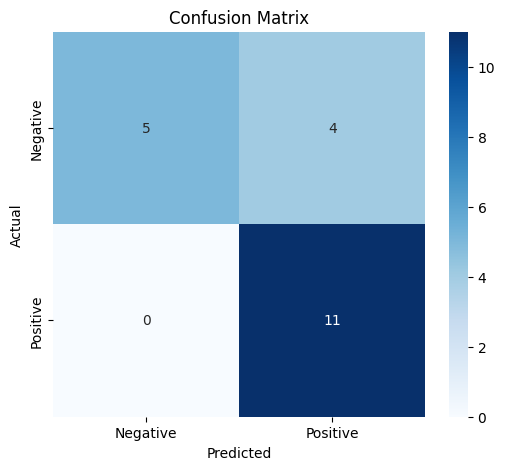


🧪 TESTING MODEL ON EXAMPLES

💬 INTERACTIVE SENTIMENT PREDICTION
Enter customer feedback to analyze sentiment.
Type '000' and press Enter to exit.

✅ Predicted Sentiment: Positive
🎯 Confidence: 0.535
📊 Class Probabilities:
   • Negative: 0.465
   • Positive: 0.535
⚠️  Please enter some text.

✅ Predicted Sentiment: Positive
🎯 Confidence: 0.534
📊 Class Probabilities:
   • Negative: 0.466
   • Positive: 0.534

✅ Predicted Sentiment: Positive
🎯 Confidence: 0.537
📊 Class Probabilities:
   • Negative: 0.463
   • Positive: 0.537
⚠️  Please enter some text.
⚠️  Please enter some text.
👋 Exiting. Thank you for using the sentiment analyzer!

✅ Training and testing complete! Model is ready for inference.


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # Fixed import
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === 1. LOAD AND CLEAN DATASET ===
# Read raw lines to handle triple-quote format
with open('sentiment-analysis.csv', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Extract header and data lines
header = lines[0].strip().strip('"')
data_lines = [line.strip() for line in lines[1:] if line.strip() and line.count('""') >= 2]

# Parse each line: the format is """text"", Sentiment, ..."
parsed_data = []
for line in data_lines:
    if not line.startswith('"""'):
        continue
    # Remove outer quotes and split carefully
    line = line.strip()
    # Remove starting and ending quote if present
    if line.endswith('"'):
        line = line[:-1]
    # Split by ", " but only after the first field
    parts = line.split('", ')
    if len(parts) < 2:
        continue
    text_with_quotes = parts[0]
    # Remove leading triple quotes
    if text_with_quotes.startswith('"""'):
        text = text_with_quotes[3:]
    elif text_with_quotes.startswith('"'):
        text = text_with_quotes[1:]
    else:
        text = text_with_quotes
    sentiment = parts[1].split(',')[0].strip()
    if sentiment in ['Positive', 'Negative']:
        parsed_data.append([text, sentiment])

# Create DataFrame
df = pd.DataFrame(parsed_data, columns=['Text', 'Sentiment'])

# Remove invalid or empty rows
df = df.dropna()
df = df[df['Text'].str.len() > 0]
df = df[df['Sentiment'].isin(['Positive', 'Negative'])]

print(f"✅ Loaded {len(df)} valid samples.")
print("Label distribution:")
print(df['Sentiment'].value_counts())

# === 2. TEXT PREPROCESSING ===
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)  # Keep only words and spaces
    text = ' '.join(text.split())  # Normalize whitespace
    return text

df['processed_text'] = df['Text'].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])
num_labels = len(label_encoder.classes_)
print(f"\nClasses: {label_encoder.classes_}")

# === 3. TRAIN/VAL SPLIT ===
X_train, X_val, y_train, y_val = train_test_split(
    df['processed_text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# === 4. TOKENIZATION & DATASET ===
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = SentimentDataset(X_train, y_train, tokenizer)
val_dataset = SentimentDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# === 5. MODEL SETUP ===
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# === 6. TRAINING LOOP ===
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            preds.extend(predictions.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return preds, labels

print("\n🚀 Starting training...")
for epoch in range(3):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_preds, val_labels = evaluate(model, val_loader, device)
    acc = accuracy_score(val_labels, val_preds)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Acc: {acc:.4f}")

# === 7. FINAL EVALUATION ===
final_preds, final_labels = evaluate(model, val_loader, device)
accuracy = accuracy_score(final_labels, final_preds)
report = classification_report(final_labels, final_preds, target_names=label_encoder.classes_, output_dict=True)
f1_macro = report['macro avg']['f1-score']
f1_weighted = report['weighted avg']['f1-score']

print("\n" + "="*50)
print("📊 FINAL EVALUATION RESULTS")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# Confusion Matrix
cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# === 8. PREDICTION FUNCTION & EXAMPLES ===
def predict_sentiment(text, model, tokenizer, label_encoder, device, max_length=128):
    model.eval()
    clean_text = preprocess_text(text)
    inputs = tokenizer(
        clean_text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probs)
        pred_label = label_encoder.inverse_transform([pred_idx])[0]
        confidence = probs[pred_idx]
    return pred_label, confidence, probs

print("\n" + "="*50)
print("🧪 TESTING MODEL ON EXAMPLES")
print("="*50)

# In-sample examples (from validation set)
# === 9. INTERACTIVE PREDICTION LOOP ===
print("\n" + "="*60)
print("💬 INTERACTIVE SENTIMENT PREDICTION")
print("Enter customer feedback to analyze sentiment.")
print("Type '000' and press Enter to exit.")
print("="*60)

while True:
    user_input = input("\n📝 Enter feedback: ").strip()

    if user_input == "000":
        print("👋 Exiting. Thank you for using the sentiment analyzer!")
        break

    if not user_input:
        print("⚠️  Please enter some text.")
        continue

    try:
        pred_label, conf, probs = predict_sentiment(
            user_input, model, tokenizer, label_encoder, device
        )
        print(f"\n✅ Predicted Sentiment: {pred_label}")
        print(f"🎯 Confidence: {conf:.3f}")
        print("📊 Class Probabilities:")
        for i, cls in enumerate(label_encoder.classes_):
            print(f"   • {cls}: {probs[i]:.3f}")
    except Exception as e:
        print(f"❌ Error during prediction: {e}")

print("\n✅ Training and testing complete! Model is ready for inference.")
# === 9. SAVE THE TRAINED MODEL + TOKENIZER + LABEL ENCODER LOCALLY ===
import os
import pickle

# Create model directory
os.makedirs("model", exist_ok=True)

# 1. Save the fine-tuned model and tokenizer (this is what from_pretrained expects)
model.save_pretrained("model")
tokenizer.save_pretrained("model")

# 2. Save the LabelEncoder separately (we need it for inference)
with open("model/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Model, tokenizer, and label_encoder saved successfully to ./model/")
print("Contents of ./model/:")
print(os.listdir("model"))